## Figure 7

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import matplotlib.dates as mdates
import os

In [2]:
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['legend.edgecolor']='black'
plt.rcParams['axes.linewidth']='0.8'
plt.rcParams['xtick.bottom']= 'True'
plt.rcParams['ytick.left']= 'True'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['xtick.major.size']='3.5'
plt.rcParams['ytick.major.size']='3.5'
plt.rcParams['xtick.major.width']='0.8'
plt.rcParams['ytick.major.width']='0.8'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

plt.rc('font', size=16)   
plt.rc('axes', titlesize=16)    
plt.rc('axes', labelsize=16)   
plt.rc('xtick', labelsize=16)   
plt.rc('ytick', labelsize=16)    
plt.rc('legend', fontsize=16)  
plt.rc('figure', titlesize=20) 

## Read files

In [3]:
os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/Ozone_daily/Ozone_processed/antarctic_ozone_hole/ozone_hole_220DU/')

timestamp = xr.open_dataset('/gws/nopw/j04/vplume/mchim/netcdf_files/Ozone_daily/\
Ozone_processed/ozone_deficit/antarctic_220/cj313_daily_ozone_deficit_220DU.nc').time

#NOVOLC
dn1 = xr.open_dataset('cj313_daily_ozone_area_220DU.nc')
dn2 = xr.open_dataset('cj314_daily_ozone_area_220DU.nc')
dn3 = xr.open_dataset('cj315_daily_ozone_area_220DU.nc')
dn = (dn1+dn2+dn3)/3

#VOLC50-1
da1 = xr.open_dataset('cj348_daily_ozone_area_220DU.nc')
da2 = xr.open_dataset('cj349_daily_ozone_area_220DU.nc')
da3 = xr.open_dataset('cj350_daily_ozone_area_220DU.nc')
da = (da1+da2+da3)/3


In [4]:
def conversion(df):
    
    df['time']=timestamp
    temp = df.ozone_hole_area[:] / 1e6 # Convert from m2 to km2
    
    return temp

def concat_data(da1, da2, da3):

    da1_oct = conversion(da1)
    da2_oct = conversion(da2)
    da3_oct = conversion(da3)
    
    concat_da = xr.concat([da1_oct, da2_oct, da3_oct], dim='concat_dim')

    return concat_da

def calc_5yr_mean(df):
    
    df['year'] = df.time.dt.year
    yearly_data = [group for _, group in df.groupby('year')]

    list_5yr_mean = {}
    interval = 17
    x = 0
    for idx in range(0,interval):
        sum_list = []
        for d in range(0,360):
            temp = (yearly_data[x][d]+yearly_data[x+1][d]+yearly_data[x+2][d]+
                    yearly_data[x+3][d]+yearly_data[x+4][d])/5
            sum_list.append(temp)
        x = x+5
        sum_list2 = sum_list[210:] + sum_list[0:210] #August first
        list_5yr_mean[idx] = sum_list2
    
    return list_5yr_mean

def calc_5yr_mean_daily(da):
    
    da1 = calc_5yr_mean(da[0,:])
    da2 = calc_5yr_mean(da[1,:])
    da3 = calc_5yr_mean(da[2,:])
  
    return da1, da2, da3

def calc_decadal(d1,d2,d3,n=10):
    max_value = {}
    min_value = {}
    mean_value = {}
    
    # for each decade
    for i in range(n):
        max_temp = []
        min_temp = []
        mean_temp = []
    
        # for each day
        for x in range(360):
            max_temp.append(max(d1[i][x], d2[i][x], d3[i][x]))
            min_temp.append(min(d1[i][x], d2[i][x], d3[i][x]))
            mean_temp.append((d1[i][x]+d2[i][x]+d3[i][x])/3)
            
        max_value[i] = max_temp
        min_value[i] = min_temp
        mean_value[i] = mean_temp

    return max_value, min_value, mean_value

In [5]:
da_area = concat_data(da1, da2, da3)
dn_area = concat_data(dn1, dn2, dn3)

In [6]:
da1_5yr, da2_5yr, da3_5yr = calc_5yr_mean_daily(da_area)
dn1_5yr, dn2_5yr, dn3_5yr = calc_5yr_mean_daily(dn_area)

In [7]:
max_ensem, min_ensem, mean_ensem = calc_decadal(da1_5yr, da2_5yr, da3_5yr)
max_nv_ensem, min_nv_ensem, mean_nv_ensem = calc_decadal(dn1_5yr, dn2_5yr, dn3_5yr)

/tmp/ipykernel_7426/2265682838.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(month_string, fontsize = 18)


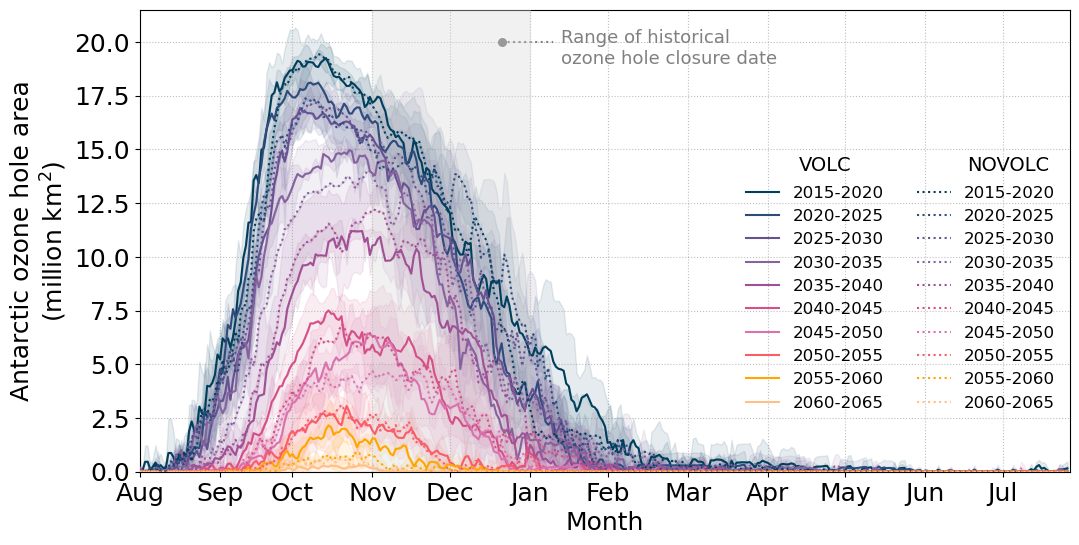

In [8]:
plt.rcParams['text.usetex']=False
plt.rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(figsize=(12,6),dpi=100)
ax.grid(which='major', color='grey', linestyle='dotted', alpha = 0.5)

day = np.arange(0,360,1)
color = ['#003f5c', '#2f4b7c', '#665191', '#86639e', '#a05195',
         '#d45087', '#d973af', '#f95d6a', '#ffa600', '#ffbf86']
labels = ['2015-2020','2020-2025','2025-2030','2030-2035','2035-2040',
          '2040-2045','2045-2050','2050-2055','2055-2060','2060-2065']
month_string = ['Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul']

n = 10

for x in range(n):
    ax.plot(day, mean_ensem[x], label = labels[x], zorder = 10, color = color[x])
    
    ax.fill_between(day, mean_ensem[x], max_ensem[x], color = color[x], alpha = 0.1)

    ax.fill_between(day, mean_ensem[x], min_ensem[x],color = color[x], alpha = 0.1)

for x in range(n):
    ax.plot(day, mean_nv_ensem[x], label = labels[x], linestyle = 'dotted', color = color[x], zorder = 11) 
    
    ax.fill_between(day, mean_nv_ensem[x], max_nv_ensem[x], color = color[x], alpha = 0.1)

    ax.fill_between(day, mean_nv_ensem[x], min_nv_ensem[x], color = color[x], alpha = 0.1)    

ax.axvspan(90,151, color = 'lightgrey', alpha = 0.3, zorder = 4)
ax.text(163, 19, 'Range of historical\nozone hole closure date', color = 'grey',fontsize = 13, zorder = 12)
ax.scatter(140,20, s=30, color='grey')
ax.hlines(20,140,160,color='grey',lw=1.5, ls = 'dotted')

ax.text(255,14, 'VOLC', weight="light", fontsize = 14)
ax.text(320,14, 'NOVOLC', weight="light",fontsize = 14)

#figure adjustment
ax.set_ylabel('Antarctic ozone hole area\n(million km$^2$)', fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.set_xlim(0,360)
ax.set_ylim(0, 21.5)
ax.set_xticklabels(month_string, fontsize = 18)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_xlabel('Month',fontsize=18)
ax.legend(loc="lower right", fontsize = 12,frameon=False,ncol=2, bbox_to_anchor=(1, 0.1))